# Why do we need to pre-process time series data?
In most cases, when we feed complete data into [*compute*](https://matrixprofile.docs.matrixprofile.org/api.html#matrixprofile-compute) and [*analyze*](https://matrixprofile.docs.matrixprofile.org/api.html#matrixprofile-analyze) functions to compute matrix profiles and analyze time series, all matrix profile algorithms would work well. However, it is inevitable that we have to work with some time series with missing values. In this case, if we don't take steps to handle these missing values, we will get into trouble calculating and analyzing matrix profiles.

The following is an example that will give you an idea of one of the potential problems caused by missing values. To create a time series containing missing data, we insert 'np.nan' and 'np.inf' into the sample dataset used in [Quickstart Guide](https://matrixprofile.docs.matrixprofile.org/Quickstart.html). After that, we try to invoke *compute* and *analyze* functions to analyze the time series we created.

In [2]:
# Import Library
import matrixprofile as mp
import numpy as np
from matplotlib import pyplot as plt
# ignore matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

[ 0.3524921   0.34628064  0.34322172  0.32580627  0.29201275  0.27735623
  0.28328524  0.29353866  0.30259366  0.30245875  0.29325783  0.28670776
  0.2891161   0.27326822  0.26599104  0.26778939  0.27401618  0.28752641
  0.2735069   0.29383559  0.3013937   0.29553578  0.27517326  0.29707322
  0.29201275  0.27735623  0.28328524  0.29353866  0.30259366  0.30245875
  0.30284275  0.29632738  0.29299616  0.27326822  0.26599104  0.26778939
  0.27401618  0.28752641  0.2735069   0.29383559  0.3013937   0.29553578
  0.27517326  0.29707322  0.29634663  0.30099944  0.29869319  0.30675545
  0.31605481  0.30861558  0.29325783  0.28670776  0.2891161   0.27925098
  0.2760615   0.2826953   0.29079211  0.29488062  0.29928782  0.31948651
  0.31036921  0.30410852  0.29756674  0.30407931  0.29960505  0.30823594
  0.30305364  0.31327603 11.3137085  11.3137085  11.3137085  11.3137085
 11.3137085  11.3137085  11.3137085  11.3137085  11.3137085  11.3137085
 11.3137085  11.3137085  11.3137085  11.3137085  11.3

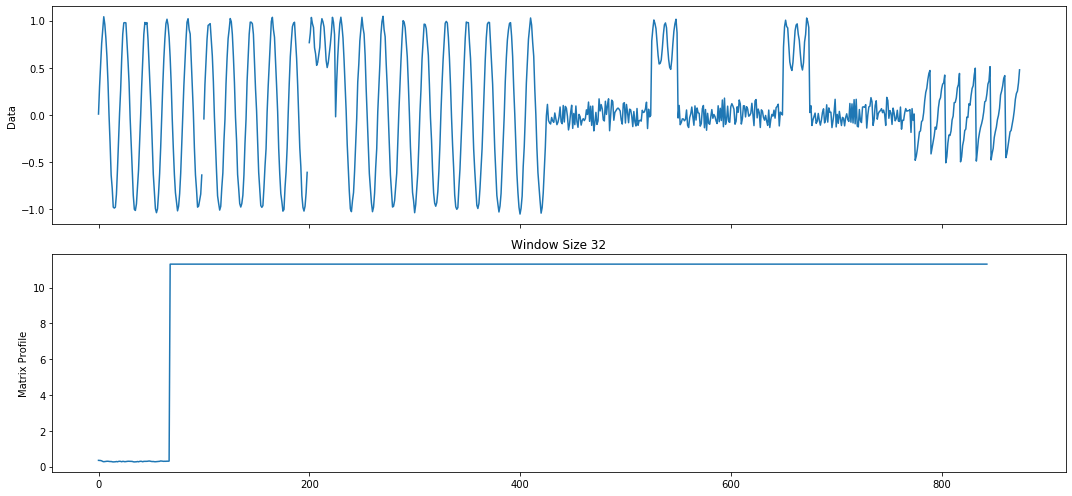

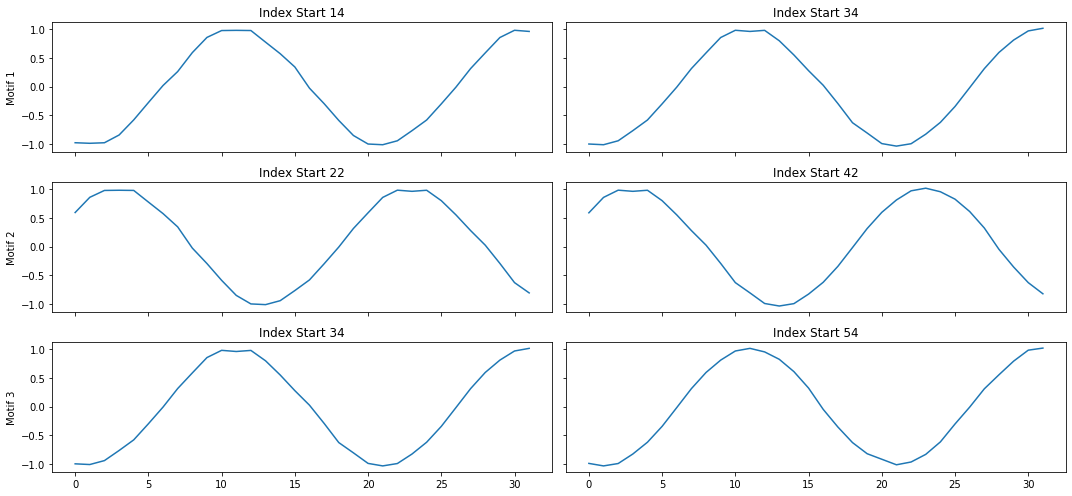

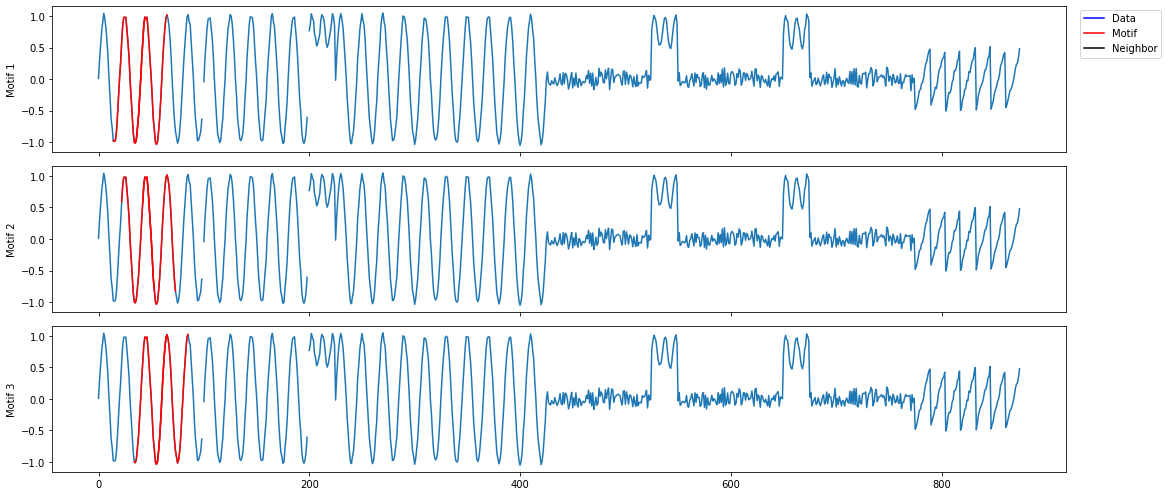

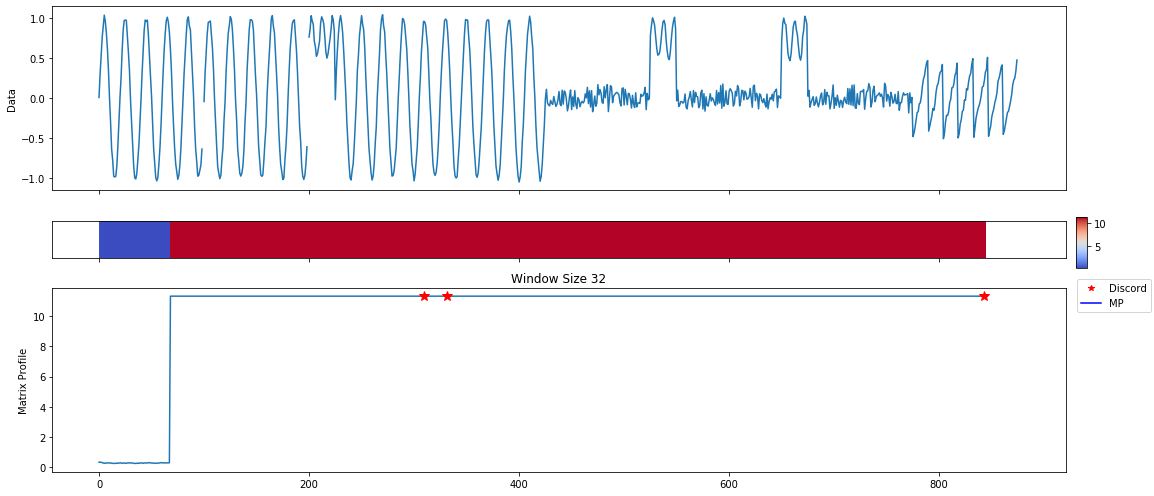

In [3]:
# Load Data
dataset = mp.datasets.load('motifs-discords-small')
ts = dataset['data']

# Add missing data to the original time series
ts[99] = np.nan
ts[199] = np.inf

# Compute and analyze the MatrixProfile
profile = mp.compute(ts, windows=32)
print(profile['mp'][:120])

profile, figures = mp.analyze(ts, windows=32)

We can see from the output and the first two plots that as long as we have missing data somewhere in the time series, the matrix profile values would become constant from the starting position of the subsequence containing the first missing data (which is 68 for this example). You may also see the problems we've run into easily by comparing the above results with the results shown in [Quickstart Guide](https://matrixprofile.docs.matrixprofile.org/Quickstart.html#Analyzing-MatrixProfile). Clearly, this matrix profile is meaningless, and we are not able to identify the correct motifs and discords based on such a matrix profile.

Therefore, in order to address the potential issues caused by missing data, we introduce a new *preprocess* module that can help you deal with these issues in some cases.

# Introduce a preprocessing procedure to avoid potential problems with computing and analyzing MatrixProfiles

## Enable preprocessing in *compute* and *analyze* functions
*Compute* and *analyze* methods now accept a new parameter *preprocessing_kwargs* of type dict to enable preprocessing. A valid *preprocessing_kwargs* has the following data structure:

In [ ]:
{
    # The window size of type int to compute the mean/median/minimum/
    # maximum value. The default is 4.
    'window': 4,
    
    # A string indicating the data imputation method, which should be 
    #'mean', 'median', 'min' or 'max'. The default is 'mean'.
    'method': 'mean',
    
    # A string indicating the data imputation direction, which should be 
    # 'forward', 'fwd', 'f', 'backward', 'bwd', 'b'. If the direction is 
    # forward, we use previous data for imputation; if the direction is
    # backward, we use subsequent data for imputation. 
    # The defualt is 'forward'.
    'direction': 'forward',
    
    # A boolean value indicating whether noise needs to be added into the
    # time series. The default is True.
    'add_noise': True
}

After defining the *preprocessing_kwargs*, we can enable the preprocessing procedures to impute the missing data in time series. Let's go back to the time series we just created in the previous section and see what will happen to the results after passing in the parameter *preprocessing_kwargs* to the *compute* and *analyze* methods.

[0.31603817 0.30619706 0.30307844 0.29103086 0.28242058 0.25885435
 0.26178487 0.26298512 0.26445091 0.26975771 0.26682685 0.26496043
 0.25899444 0.24459888 0.22846792 0.22436775 0.22991552 0.24116657
 0.25282172 0.26204652 0.27500821 0.27407045 0.25155684 0.24706898
 0.2269333  0.23478714 0.24319875 0.2605994  0.25807781 0.26123489
 0.26173181 0.25653847 0.24557557 0.23782793 0.23510445 0.24067795
 0.25391608 0.25052436 0.25582849 0.25490393 0.25472432 0.24074507
 0.23708734 0.23448261 0.23528765 0.24191318 0.24499901 0.25154246
 0.25539121 0.24605709 0.2675543  0.24639792 0.24022651 0.23150459
 0.22415014 0.23995551 0.24344299 0.25386194 0.26955302 0.28032537
 0.28508362 0.27185279 0.26480609 0.24829441 0.24285863 0.22918342
 0.25004307 0.25345431 0.35849266 0.49543647 0.50105383 0.49806007
 0.47591045 0.46205333 0.46005262 0.45048287 0.46030838 0.47773818
 0.4914458  0.50081939 0.51002046 0.50171878 0.48617977 0.47886237
 0.47216093 0.47351297 0.49080934 0.49704537 0.50348166 0.5119

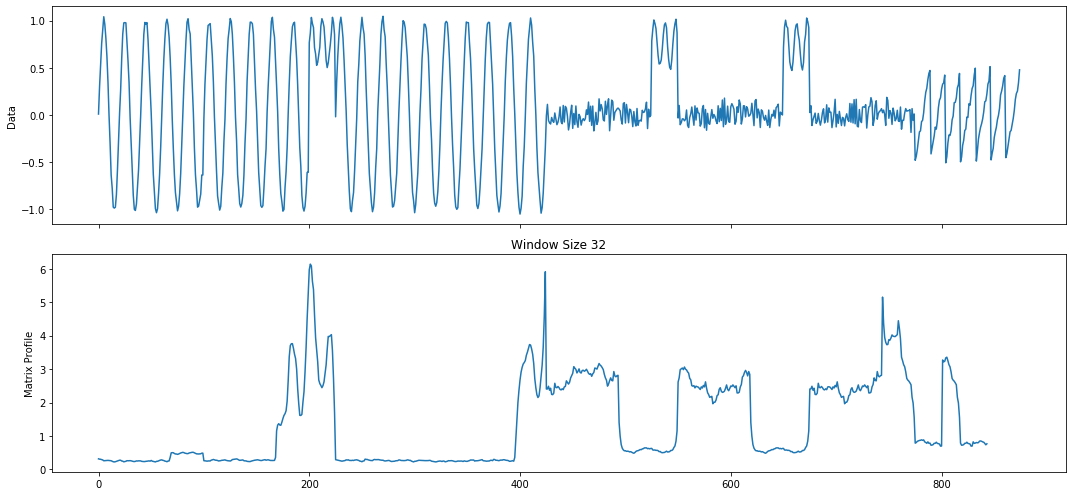

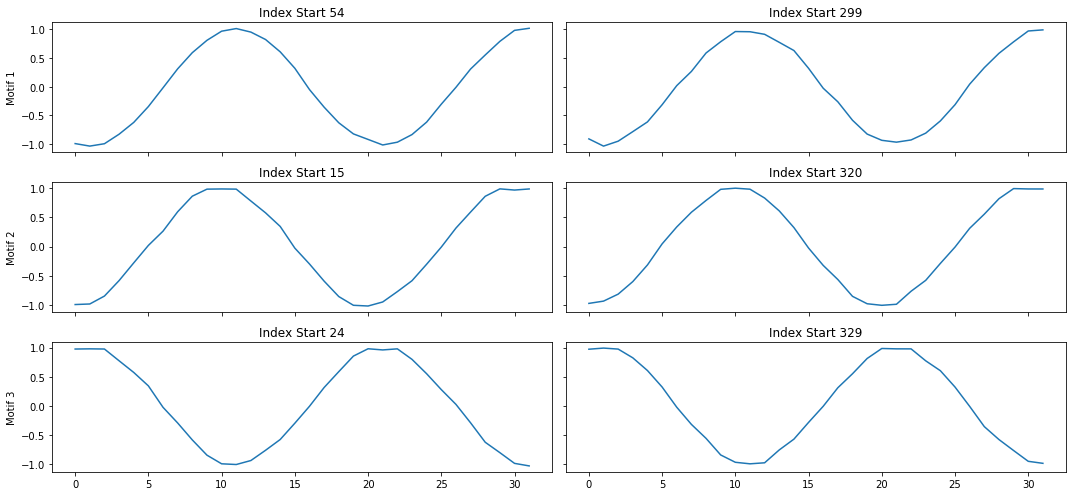

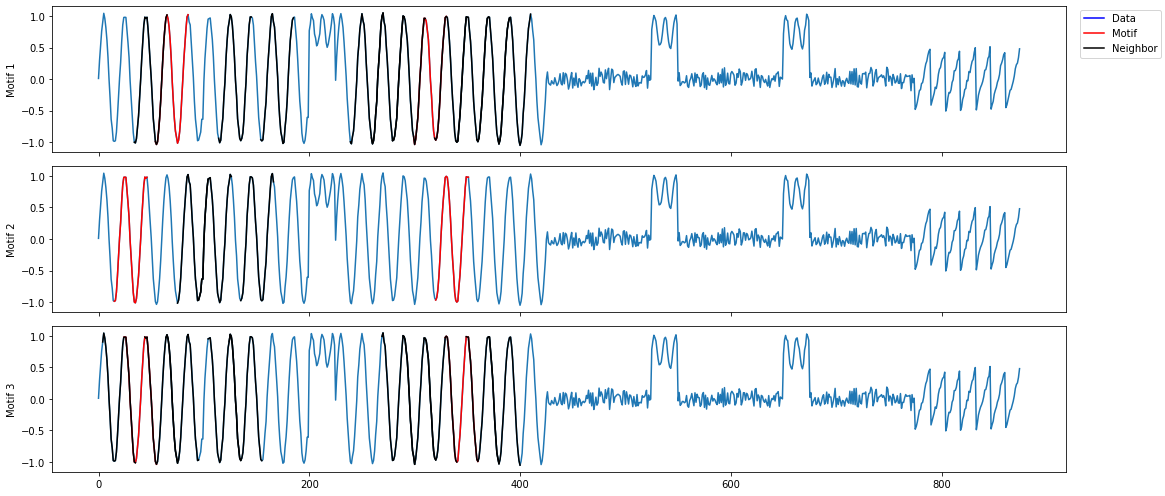

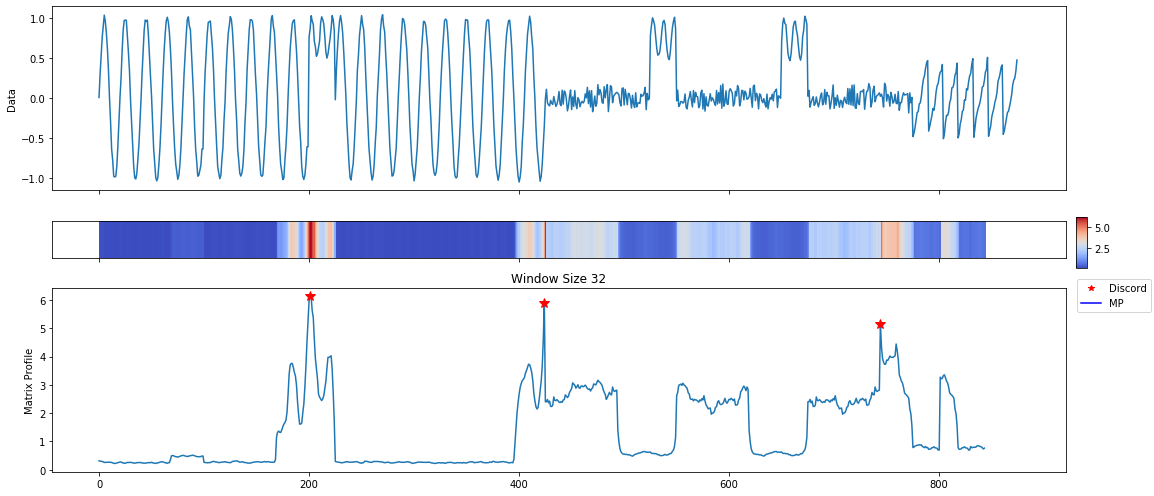

In [4]:
preprocessing_kwargs = {
    'window': 3,
    'impute_method': 'max',
    'impute_direction': 'forward',
    'add_noise': False
}

# Compute and analyze the MatrixProfile
profile = mp.compute(ts, windows=32, preprocessing_kwargs=preprocessing_kwargs)
print(profile['mp'][:120])

profile, figures = mp.analyze(ts, windows=32, preprocessing_kwargs=preprocessing_kwargs)

In this example, we use the maximum value in the sliding window for imputation. As you can see from the output and the figures above, by starting the preprocessing procedure to impute missing data, this time the matrix profile no longer has constant intervals and works properly. 

What's more, the results of motifs and discords are consistent with those shown in [Quickstart Guide](https://matrixprofile.docs.matrixprofile.org/Quickstart.html#Analyzing-MatrixProfile), and there is no significant difference between the matrix profile in this example and that for the original time series.

## Invoke the *preprocess* module directly
If you simply want to preprocess your time series data without computing and analyzing matrix profiles, we provide you with another option, which is to invoke the *preprocess* module directly. To accommodate your different needs for data processing, the *preprocess* module has the following features:

1. Preprocessing
2. Data imputation
3. Adding noise
4. Constant Value Detection

In the following sections, we will illustrate each one of them with examples.

### matrixprofile.preprocess.preprocess

#### Description
Imputes missing data in time series, and adds noise if the data within the sliding window are constant.

#### Parameters
<table width="100%">
    <thead>
        <tr>
            <th style="text-align: left; width: 110px;">Parameters</th>
            <th style="text-align: left; width: 150px;">Type</th>
            <th style="text-align: left">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"><strong>ts</strong></td>
            <td style="text-align: left">array_like</td>
            <td style="text-align: left">The time series to be preprocessed.</td>
        </tr>
        <tr>
            <td style="text-align: left"><strong>window</strong></td>
            <td style="text-align: left">int</td>
            <td style="text-align: left">The window size to compute the mean/median/minimum value/maximum value.</td>
        </tr>
        <tr>
            <td style="text-align: left"><strong>impute_method</strong></td>
            <td style="text-align: left">string, default = 'mean'</td>
            <td style="text-align: left">A string indicating the data imputation method, which should be 'mean',      'median', 'min' or 'max'.</td>
        </tr>
        <tr>
            <td style="text-align: left"><strong>impute_direction</strong></td>
            <td style="text-align: left">string, default = 'forward'</td>
            <td style="text-align: left">A string indicating the data imputation direction, which should be 'forward', 'fwd', 'f', 'backward', 'bwd', 'b'. If the direction is forward, we use previous data for imputation; if the direction is backward, we use subsequent data for imputation.</td>
        </tr>
        <tr>
            <td style="text-align: left"><strong>add_noise</strong></td>
            <td style="text-align: left">bool, default = True</td>
            <td style="text-align: left">A boolean value indicating whether noise needs to be added into the time series.</td>
        </tr>
    </tbody>
</table>

#### Returns
<table width="100%">
    <thead>
        <tr>
            <th style="text-align: left; width: 110px;">Returns</th>
            <th style="text-align: left; width: 150px;">Type</th>
            <th style="text-align: left">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"><strong>temp</strong></td>
            <td style="text-align: left">array_like</td>
            <td style="text-align: left">The preprocessed time series.</td>
        </tr>
    </tbody>
</table>

#### Examples

In [6]:
from matrixprofile.preprocess import preprocess

ts = np.array([np.nan, np.inf, np.nan, 2, 3, 4, 5, np.nan, 
               np.inf, np.inf, np.nan, 1, 1, 1, 1])
preprocess(ts, window=4, impute_method='mean', impute_direction='fwd', add_noise=True)

array([2.00000089, 2.00000005, 2.00000053, 2.00000042, 3.        ,
       4.        , 5.        , 4.        , 4.33333333, 4.44444444,
       4.25925926, 1.00000025, 1.00000059, 1.00000058, 1.00000018])

In [19]:
ts = np.array([1, 1, 1, 1, np.nan, np.inf, 6, 4, 5, np.inf, np.nan, 2, 1])
preprocess(ts, window=3, impute_method='median', impute_direction='b', add_noise=True)

array([1.00000043, 1.00000047, 1.00000046, 1.        , 5.5       ,
       5.        , 6.        , 4.        , 5.        , 1.75      ,
       1.5       , 2.        , 1.        ])

### matrixprofile.preprocess.impute_missing

#### Description
Imputes missing data in time series.

#### Parameters
<table width="100%">
    <thead>
        <tr>
            <th style="text-align: left; width: 110px;">Parameters</th>
            <th style="text-align: left; width: 150px;">Type</th>
            <th style="text-align: left">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"><strong>ts</strong></td>
            <td style="text-align: left">array_like</td>
            <td style="text-align: left">The time series to be handled.</td>
        </tr>
        <tr>
            <td style="text-align: left"><strong>window</strong></td>
            <td style="text-align: left">int</td>
            <td style="text-align: left">The window size to compute the mean/median/minimum value/maximum value.</td>
        </tr>
        <tr>
            <td style="text-align: left"><strong>method</strong></td>
            <td style="text-align: left">string, default = 'mean'</td>
            <td style="text-align: left">A string indicating the data imputation method, which should be 'mean',      'median', 'min' or 'max'.</td>
        </tr>
        <tr>
            <td style="text-align: left"><strong>direction</strong></td>
            <td style="text-align: left">string, default = 'forward'</td>
            <td style="text-align: left">A string indicating the data imputation direction, which should be 'forward', 'fwd', 'f', 'backward', 'bwd', 'b'. If the direction is forward, we use previous data for imputation; if the direction is backward, we use subsequent data for imputation.</td>
        </tr>
    </tbody>
</table>

#### Returns
<table width="100%">
    <thead>
        <tr>
            <th style="text-align: left; width: 110px;">Returns</th>
            <th style="text-align: left; width: 150px;">Type</th>
            <th style="text-align: left">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"><strong>temp</strong></td>
            <td style="text-align: left">array_like</td>
            <td style="text-align: left">The time series after being imputed missing data. </td>
        </tr>
    </tbody>
</table>

#### Examples

In [14]:
from matrixprofile.preprocess import impute_missing

ts = np.array([np.nan, np.inf, np.nan, 2, 3, 4, 5, np.nan, 
               np.inf, np.inf, np.nan, 1, 1, 1, 1])
impute_missing(ts, window = 4, method='mean', direction='f')

array([2.        , 2.        , 2.        , 2.        , 3.        ,
       4.        , 5.        , 4.        , 4.33333333, 4.44444444,
       4.25925926, 1.        , 1.        , 1.        , 1.        ])

In [17]:
ts = np.array([1, 1, 1, 1, np.nan, np.inf, 6, 4, 5, np.inf, np.nan, 2, 1])
impute_missing(ts, window=3, method='median', direction='b')

array([1.  , 1.  , 1.  , 1.  , 5.5 , 5.  , 6.  , 4.  , 5.  , 1.75, 1.5 ,
       2.  , 1.  ])

### matrixprofile.preprocess.add_noise_to_series

#### Description
Adds noise to the given time series.

#### Parameters
<table width="100%">
    <thead>
        <tr>
            <th style="text-align: left; width: 110px;">Parameters</th>
            <th style="text-align: left; width: 150px;">Type</th>
            <th style="text-align: left">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"><strong>series</strong></td>
            <td style="text-align: left">array_like</td>
            <td style="text-align: left">The time series subsequence to be added noise.</td>
        </tr>
    </tbody>
</table>

#### Returns
<table width="100%">
    <thead>
        <tr>
            <th style="text-align: left; width: 110px;">Returns</th>
            <th style="text-align: left; width: 150px;">Type</th>
            <th style="text-align: left">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"><strong>temp</strong></td>
            <td style="text-align: left">array_like</td>
            <td style="text-align: left">The time series subsequence with noise added.</td>
        </tr>
    </tbody>
</table>

#### Examples

In [59]:
from matrixprofile.preprocess import add_noise_to_series

ts = np.array([1, 1, 1, 1, 1])
add_noise_to_series(ts)

array([1.00000015, 1.00000024, 1.00000032, 1.00000036, 1.00000081])

### matrixprofile.preprocess.is_subsequence_constant

#### Description
Determines whether the given time series subsequence is an array of constants.

#### Parameters
<table width="100%">
    <thead>
        <tr>
            <th style="text-align: left; width: 110px;">Parameters</th>
            <th style="text-align: left; width: 150px;">Type</th>
            <th style="text-align: left">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"><strong>subsequence</strong></td>
            <td style="text-align: left">array_like</td>
            <td style="text-align: left">The time series subsequence to analyze.</td>
        </tr>
    </tbody>
</table>

#### Returns
<table width="100%">
    <thead>
        <tr>
            <th style="text-align: left; width: 110px;">Returns</th>
            <th style="text-align: left; width: 150px;">Type</th>
            <th style="text-align: left">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"><strong>is_constant</strong></td>
            <td style="text-align: left">bool</td>
            <td style="text-align: left">A boolean value indicating whether the given subsequence is an array of constants.</td>
        </tr>
    </tbody>
</table>

#### Examples

In [42]:
from matrixprofile.preprocess import is_subsequence_constant

ts = np.array([1, 1, 1, 1, 1])
is_subsequence_constant(ts)

True

In [41]:
ts = np.array([1, 2, 1, 1, 1, 1])
is_subsequence_constant(ts)

False

## Limitations of the current data imputation method

If the missing data in a time series are continuous and in large quantity, it is difficult for our current data imputation method to provide accurate predictions of the missing values. As can be seen from the figure below, when the amount of missing data increases to 200, the dispersion of the imputed data is fairly low. That's because the imputed data is only affected by other available data within the window. To utilize the data farther away from the missing data for imputation, we may need to introduce some more intelligent algorithms to learn the overall pattern of the time series or the long-range dependencies between the data, which are beyond the capability of the current implementation.

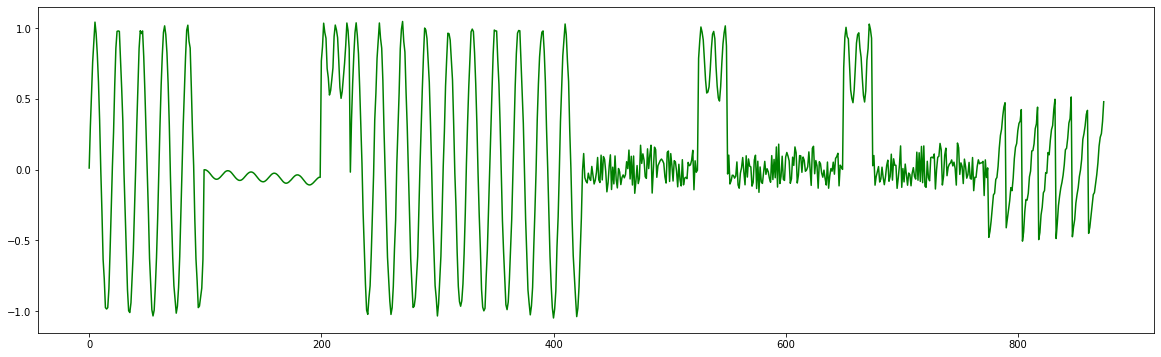

In [49]:
# Load Data
dataset = mp.datasets.load('motifs-discords-small')
ts = dataset['data']

# Add missing data to the original time series
ts[99:200] = np.nan

ts = preprocess(ts, window=100)
plt.figure(figsize=(20,6))
plt.plot(ts,'g')
plt.show()